# Eccentric ring widths
Code to generate most of the figures in the eccentric width paper. The dd and alma packages are also in my github.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.ndimage
from astropy.io import fits
import matplotlib.patches as patches

import dd.dynamics
import alma.image

%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plt.rcParams.update({'font.size': 15})

In [3]:
# function to make an image plus e-omega space
def e_img(p, xlim=None, ylim=None, da_gauss=True, r_prof=False, npix=512, n_p=10000000,
          eg=False, title=True, yoff=False):

    npx = npix
    aspp = p[6]*2.7 / npx
    x = np.linspace(-npx//2, npx//2, num=npx)

    if eg:
        ef, ep, e = eccentric_ring_image_eg(p, None, None, return_e=True, n=1000)
        im = eccentric_ring_image_eg(p, npx, aspp, return_e=False, da_gauss=da_gauss, n=n_p)
    else:
        ef, ep, e = alma.image.eccentric_ring_image(p, None, None, return_e=True, n=1000)
        im = alma.image.eccentric_ring_image(p, npx, aspp, return_e=False, da_gauss=da_gauss, n=n_p)

#     if yoff:
#         fig, ax = plt.subplots(1,2, figsize=(5,3.5))
#     else:
    fig, ax = plt.subplots(1,2, figsize=(6,3.5))
    ax[0].scatter(np.real(e), np.imag(e), s=1, c='blue', label='$e_{final}$', alpha=0.5)
    ax[0].scatter(np.real(ep), np.imag(ep), s=1, c='orange', label='$e_0$', alpha=0.5)
    ax[0].plot(np.real(ef), np.imag(ef), '+b')
    ax[0].plot(0, 0, 'xb')
#     ax[0].legend(frameon=False,loc=2)
    if xlim is None:
        ax[0].set_xlim(np.min(np.real([e,ep])), np.max(np.real([e,ep])))
    else:
        ax[0].set_xlim(xlim)
    if ylim is None:
        ax[0].set_ylim(np.min(np.imag([e,ep])), np.max(np.imag([e,ep])))
    else:
        ax[0].set_ylim(ylim)
#     ax[0].axis('equal')
    ax[0].set_aspect(1.0)
    ax[0].set_xlabel('$e cos{\omega}$')
    if not yoff:
        ax[0].set_ylabel('$e sin{\omega}$')

    ax[1].imshow(im, origin='bottom', cmap='Greys')
    ax[1].plot((npx-1)/2, (npx-1)/2, '+b')
#     ax[1].axis('off')
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
    
    # radial cut along x axis
    if r_prof:
        w = 20
        line = np.mean(im[npx//2-w//2:npx//2+w//2,:], axis=0)
        line = line/np.max(line) * ax[1].get_ylim()[1] / 3 + npx/2
        ax[1].plot(x+npx//2, line)
        
    xoff = 15
    ax[1].set_xlim(0-xoff, npx-xoff)
    ax[1].set_ylim(0, npx)
    
    # azimuthal sum
#     xx, yy = np.meshgrid(x, x)
#     theta = np.arctan2(yy,xx)
#     nth = 100
#     bins = np.linspace(-np.pi, np.pi, num=nth, endpoint=True)
#     binc = (bins[:-1]+bins[1:])/2
#     bini = np.digitize(theta, bins)
#     f_th = np.zeros(nth-1)
#     for i in range(nth-1):
#         im_tmp = np.copy(im)
#         im_tmp[(bini-1) != i] = 0
#         f_th[i] = np.sum(im_tmp)
        
    left = 0.16
    fig.subplots_adjust(left=left, bottom=0.15, top=0.9, right=0.99)
    fig.subplots_adjust(wspace=0.02)

#     ax_pol = fig.add_axes(ax[1].get_position(), projection = 'polar')
#     ax_pol.plot(binc, f_th/np.max(f_th)*npx/6)
#     ax_pol.set_ylim(0,npx/2)
#     ax_pol.axis('off')
    
    if da_gauss:
        da_str = '$\sigma_a/a$'
    else:
        da_str = '$\delta_a/a$'
        
    if title:
        fig.suptitle(r'$e_f$:{:4.2f}, $e_p$:{:4.2f}, '
                     r'$\sigma_{{e,p}}$:{:4.2f}, {}:{:4.2f}'.format(p[8],p[10],p[11],da_str,p[7]/p[6]),
                    fontsize=15, y=0.95)
#         ax[0].set_title(r'$e_f$:{:4.2f}, $e_p$:{:4.2f}, '
#                         r'$\sigma_{{e,p}}$:{:4.2f}, {}:{:4.2f}'.format(p[8],p[10],p[11],da_str,p[7]/p[6]))
    return fig

<IPython.core.display.Javascript object>


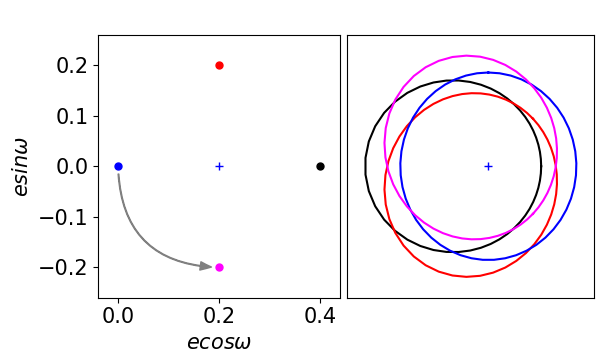

In [30]:
# custom cartoon plot
fig, ax = plt.subplots(1,2, figsize=(6,3.5))

p = [0, 0,
     -90, 0, 0, 0.0148,
     1.0, 0.001, 0.15, 0.1,
     0.15, 0.0001, 0]

ep0 = 0.2
ep = ep0 * np.exp(1j*np.linspace(0,2*np.pi,4,endpoint=False))
e = ep + ep0

c = ['black','red','blue','magenta']
for i in range(len(e)):
    ax[0].plot(np.real(e[i]), np.imag(e[i]), 'o', color=c[i], markersize=5)
    f = np.linspace(0, 2*np.pi, 50)
    r = 1 * (1-np.abs(e[i])**2)/(1+np.abs(e[i])*np.cos(f))
    ax[1].plot(r*np.cos(f+np.angle(e[i])), r*np.sin(f+np.angle(e[i])), color=c[i])

ax[0].plot(ep0, 0, '+b')
ax[1].plot(0, 0, '+b')
# ax[0].plot(0, 0, 'xb')

style="Simple,tail_width=0.5,head_width=6,head_length=8"
kw = dict(arrowstyle=style, color="grey")

a1 = patches.FancyArrowPatch((0,-0.01), (0.19,-0.2),connectionstyle="arc3,rad=0.45", **kw)
ax[0].add_patch(a1)

xlim=[-0.04,0.44]
ylim=[-0.26,0.26]
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
ax[0].set_aspect(1.0)
ax[0].set_xlabel('$e cos{\omega}$')
ax[0].set_ylabel('$e sin{\omega}$')

ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

xlim = [-1.6, 1.2]
ylim = np.array([-1,1])*(xlim[1]-xlim[0])/2
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)

fig.subplots_adjust(left=0.16, bottom=0.15, top=0.9, right=0.99)
fig.subplots_adjust(wspace=0.02)

fig.savefig('figs/eg0.pdf')

<IPython.core.display.Javascript object>


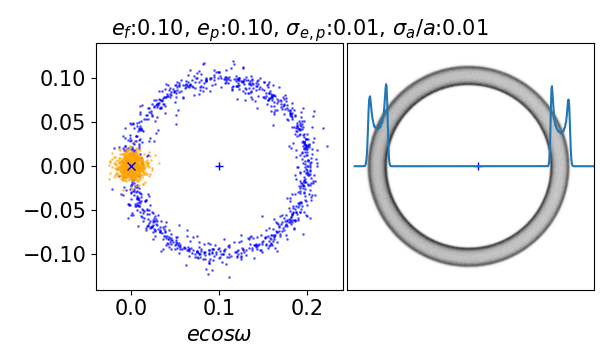

<IPython.core.display.Javascript object>


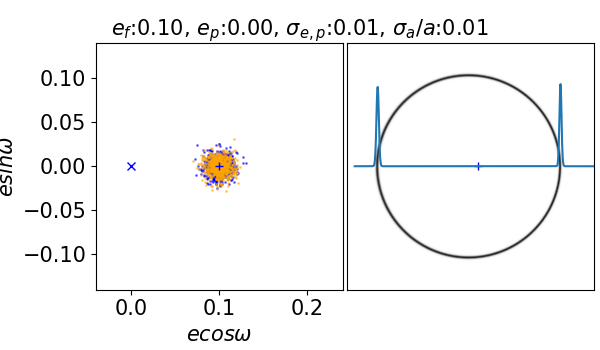

<IPython.core.display.Javascript object>


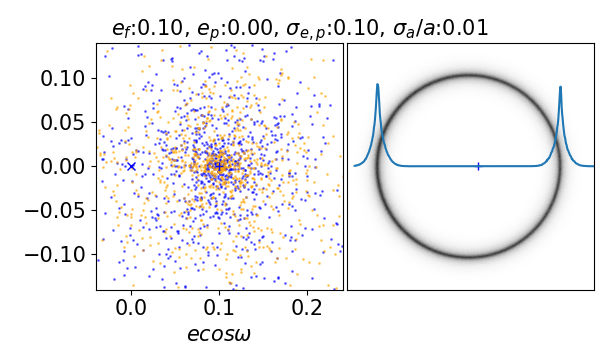

<IPython.core.display.Javascript object>


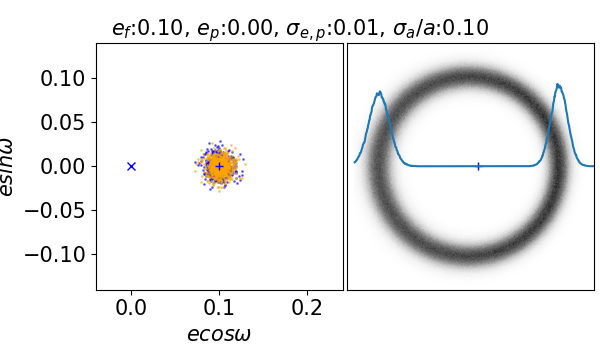

In [6]:
# example
p0 = [0, 0,
     -90, 0, 0, 0.0148,
     1.0, 0.01, 0.1, 0.1,
     0.1, 0.01, 0]

fig = e_img(p0, xlim=[-0.04,0.24], ylim=[-0.14,0.14], r_prof=True, yoff=True)
fig.savefig('figs/eg1.pdf')
p0[9:11] = [0,0]
fig = e_img(p0, xlim=[-0.04,0.24], ylim=[-0.14,0.14], r_prof=True)
fig.savefig('figs/eg2.pdf')
p0[11] = 0.1
fig = e_img(p0, xlim=[-0.04,0.24], ylim=[-0.14,0.14], r_prof=True, yoff=True)
fig.savefig('figs/eg3.pdf')
p0[11] = 0.01
p0[7] = 0.1
fig = e_img(p0, xlim=[-0.04,0.24], ylim=[-0.14,0.14], r_prof=True)
fig.savefig('figs/eg4.pdf')

<IPython.core.display.Javascript object>


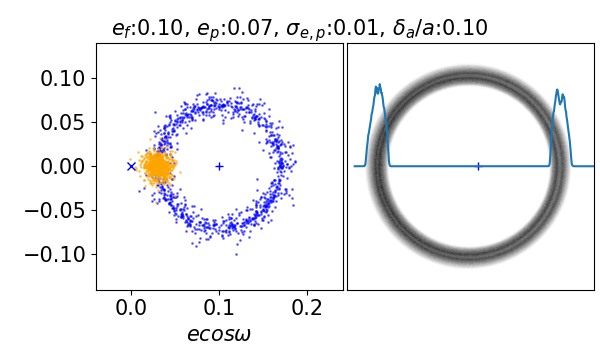

<IPython.core.display.Javascript object>


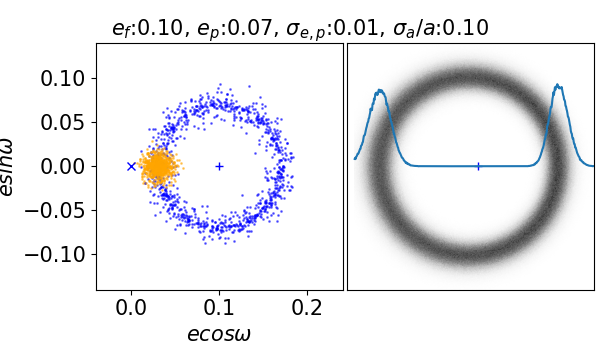

In [7]:
p0[7] = 0.1
p0[8] = 0.1
p0[10] = 0.07
# p0[11] = 0
# p0[12] = 0
fig = e_img(p0, xlim=[-0.04,0.24], ylim=[-0.14,0.14], da_gauss=False, r_prof=True, yoff=True)
fig.savefig('figs/eg5.pdf')
fig = e_img(p0, xlim=[-0.04,0.24], ylim=[-0.14,0.14], da_gauss=True, r_prof=True)
fig.savefig('figs/eg6.pdf')

<IPython.core.display.Javascript object>


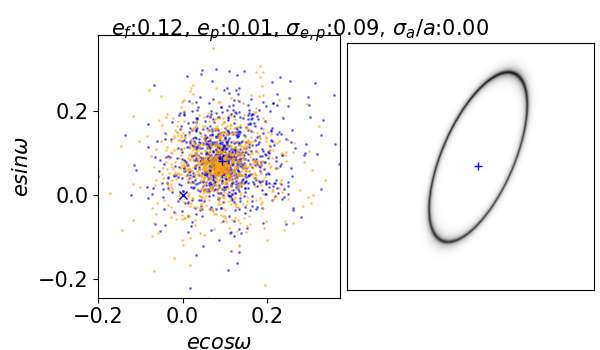

In [8]:
# fomalhaut best Gaussian fit, no star (last parameter removed)
p_fom = [-0.06393144163641921, 0.04965271605693023, 156.36589056771814, 40.682928105901716, 66.64021881043205,
         0.026647631337509425, 18.17106218297129, 0.07698642393908248, 0.12387748363420213, 0.06738840900966074,
         0.011263839089950956, 0.09292641980327256, 0.03488316867706079]

fig = e_img(p_fom)

<IPython.core.display.Javascript object>


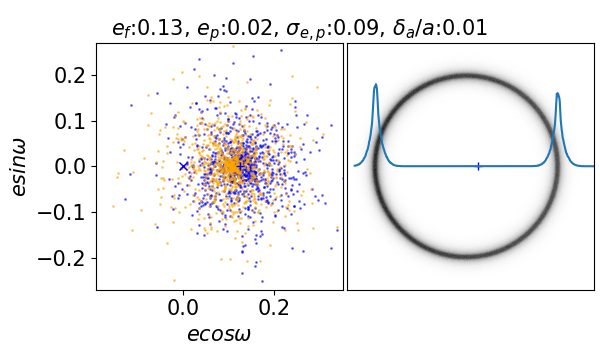

In [9]:
# fomalhaut best uniform fit, no star (last parameter removed)
p_fom = [0, 0, -90, 0, 0, 1, 18.175419514046197, 0.25666005194242225, 0.1254802730788201, 0.07257324427893146, 0.018970824700911944, 0.0893452566601199, 0.03352210929542964]

fig = e_img(p_fom, xlim=[-0.19,0.35], ylim=[-0.27,0.27], da_gauss=False, r_prof=True)
fig.savefig('figs/fom_ecc.pdf')

<IPython.core.display.Javascript object>


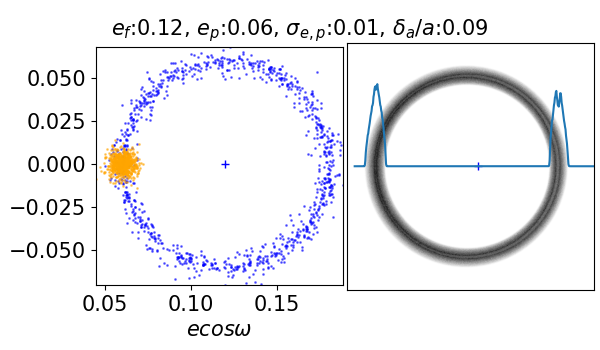

In [10]:
# MacGregor best fit
p_fom = [0, 0, -90, 0, 0,
         1, 136.3-12.2/2, 12.2, 0.12, 0, 0.06, 0.005, 0.005]
fig = e_img(p_fom, da_gauss=False, r_prof=True)

<IPython.core.display.Javascript object>


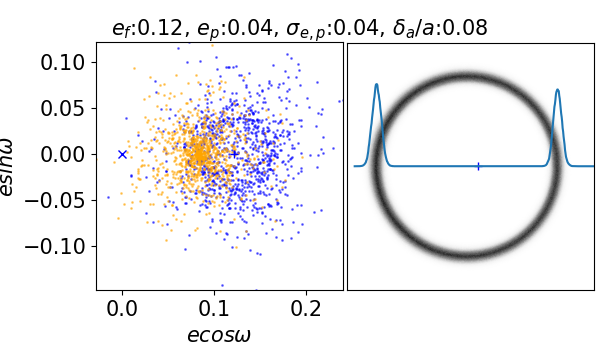

In [11]:
# HD 202628 best fit
p_hd = [0, 0, -90, 0, 0, 1, 6.5526184793016995, 0.5505305382164355, 0.12202718593615124, 0.14766738060541926, 0.038294871467477884, 0.0394081356887331, 0.10342132776583016]

fig = e_img(p_hd, da_gauss=False, r_prof=True)
# fig.savefig('figs/hd_ecc.pdf')

<IPython.core.display.Javascript object>


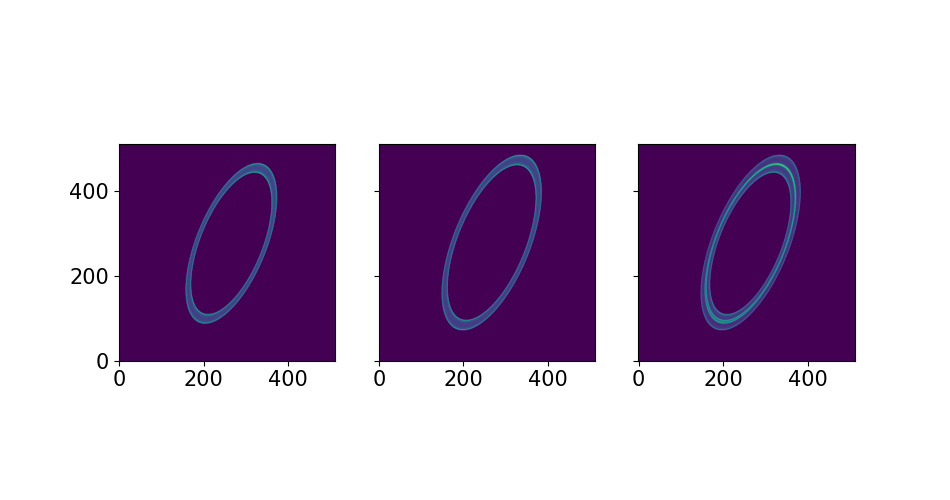

In [12]:
# illustrate the double-ring thing
p_fom = [0, 0, 337.9-180, 0, 65.6,
         1, 136.3-12.2/2, 0, 0.12, 0, 0.06, 0, 0]
npx = 512
aspp = p_fom[6]*2.7 / npx
im1 = alma.image.eccentric_ring_image(p_fom, npx, aspp, return_e=False, da_gauss=False, n=5000000)
p_fom = [0, 0, 337.9-180, 0, 65.6,
         1, 136.3+12.2/2, 0, 0.12, 0, 0.06, 0, 0]
im2 = alma.image.eccentric_ring_image(p_fom, npx, aspp, return_e=False, da_gauss=False, n=5000000)

fig, ax = plt.subplots(1,3, figsize=(9.5,5), sharex=True, sharey=True)
ax[0].imshow(im1, origin='lower')
ax[1].imshow(im2, origin='lower')
ax[2].imshow(im1+im2, origin='lower')

In [13]:
# hr4796
p0 = [0, 0,
     26.7, 20, 76.6, 0.0148,
     1.09, 0.025, 0.06, 0.1,
     0.06, 0.01, 0.1]

<IPython.core.display.Javascript object>


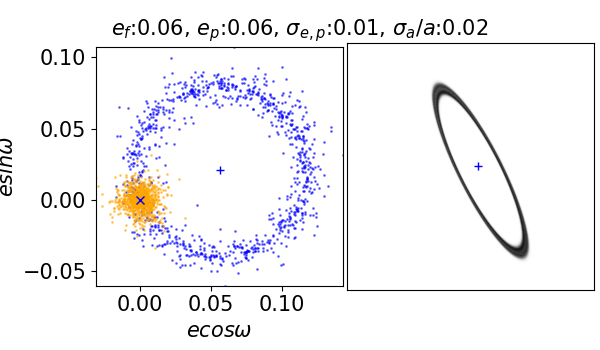

In [14]:
fig = e_img(p0)

### Radial profiles

In [31]:
plt.rcParams.update({'font.size': 14})

<IPython.core.display.Javascript object>


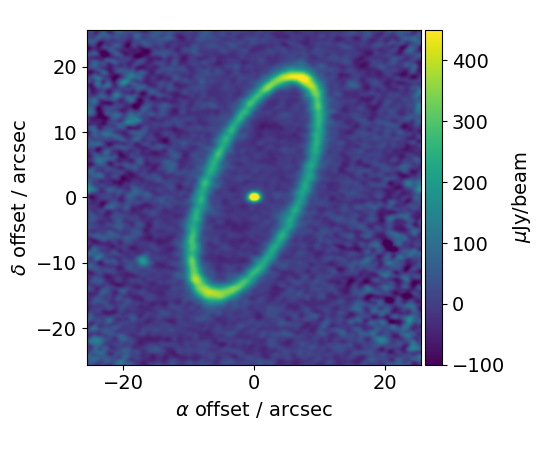

In [16]:
file = 'fomalhaut.pbcor.fits'
d = fits.getdata(file).squeeze() * 1e6
h = fits.open(file)
aspp = np.abs(h[0].header['CDELT1']*3600)
sz = d.shape[0] * aspp

fig, ax = plt.subplots(figsize=(5.5,4.5))
_ = ax.imshow(d, origin='bottom', extent=[-sz/2,sz/2,-sz/2,sz/2], vmin=-100, vmax=450)
# ax.contour(d, origin='lower', extent=[-sz/2,sz/2,-sz/2,sz/2], levels=[10*13])
# ax.plot(0,0, '+w')

cb = fig.colorbar(_, pad=0.01, shrink=0.95)
cb.ax.set_ylabel('$\mu$Jy/beam')

ax.set_xlabel(r'$\alpha$ offset / arcsec')
ax.set_ylabel(r'$\delta$ offset / arcsec')

fig.tight_layout()
fig.savefig('figs/fom.pdf')

<IPython.core.display.Javascript object>


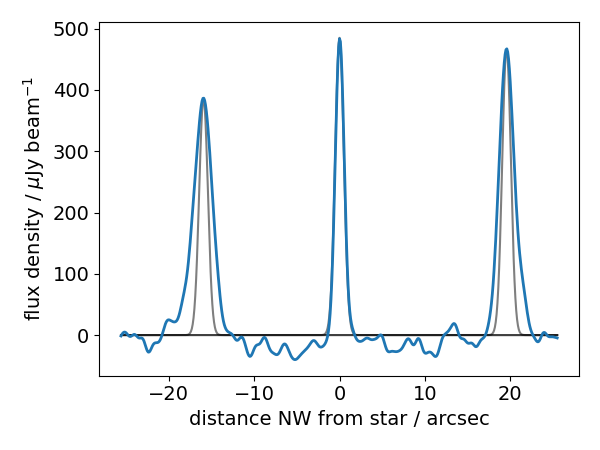

In [17]:
d = scipy.ndimage.rotate(d, 337.9, reshape=False)

w = 10
cut = np.mean(d[:,255-w:255+w], axis=1)
x = np.arange(-256,256,1)*0.1

g = lambda x,x0,s,p: p*np.exp(-(x-x0)**2 / (2*s**2))

fig, ax = plt.subplots(figsize=(6,4.5))
# _ = ax.imshow(d, origin='bottom')#, extent=[-sz/2,sz/2,-sz/2,sz/2], vmin=-40, vmax=40)
# ax.imshow(d[:,255-w:255+w], origin='bottom')
ax.plot(x, g(x, -15.93, 1.2/2.35, 386), color='black', alpha=0.5)
ax.plot(x, g(x, 19.57, 1.2/2.35, 467), color='black', alpha=0.5)
ax.plot(x, g(x, 0, 1.2/2.35, 485), color='black', alpha=0.5)
ax.plot(x, cut, color='C0', linewidth=2)
ax.set_xlabel('distance NW from star / arcsec')
ax.set_ylabel('flux density / $\mu$Jy beam$^{-1}$')

fig.tight_layout()
fig.savefig('figs/fom_rprof.pdf')

<IPython.core.display.Javascript object>


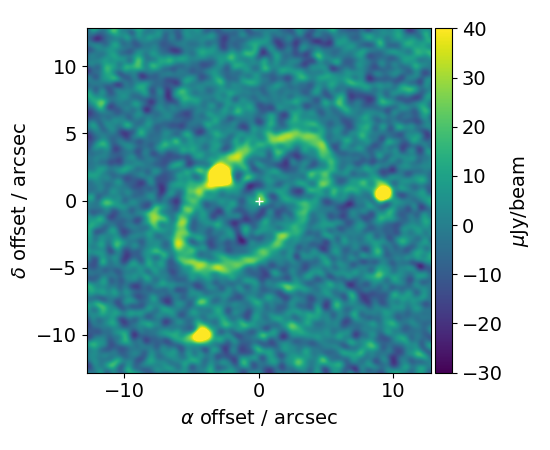

In [18]:
file = 'hd202628.fits'
d = fits.getdata(file).squeeze() * 1e6
h = fits.open(file)
aspp = np.abs(h[0].header['CDELT1']*3600)
sz = d.shape[0] * aspp

fig, ax = plt.subplots(figsize=(5.5,4.5))
_ = ax.imshow(d, origin='bottom', extent=[-sz/2,sz/2,-sz/2,sz/2], vmin=-30, vmax=40)
# ax.contour(d, origin='lower', extent=[-sz/2,sz/2,-sz/2,sz/2], levels=[2*6])
ax.plot(0,0, '+w')

cb = fig.colorbar(_, pad=0.01, shrink=0.993)
cb.ax.set_ylabel('$\mu$Jy/beam')

ax.set_xlabel(r'$\alpha$ offset / arcsec')
ax.set_ylabel(r'$\delta$ offset / arcsec')

fig.tight_layout()
fig.savefig('figs/hd202628.pdf')

### Residual images

<IPython.core.display.Javascript object>


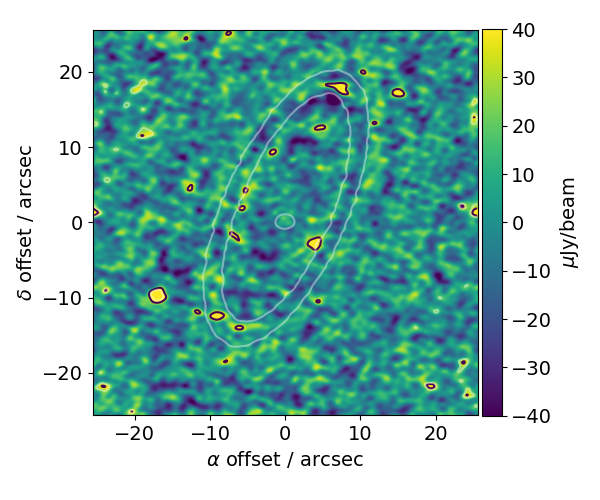

In [19]:
# Fomalhaut
im = 'da_full'
file = 'fomalhaut/multinest_{}/residuals.fits'.format(im)
d = fits.getdata(file).squeeze() * 1e6
h = fits.open(file)
aspp = np.abs(h[0].header['CDELT1']*3600)
sz = d.shape[0] * aspp

file2 = 'fomalhaut.pbcor.fits'
d2 = fits.getdata(file2).squeeze() * 1e6

fig, ax = plt.subplots(figsize=(6,5))
_ = ax.imshow(d, origin='bottom', extent=[-sz/2,sz/2,-sz/2,sz/2], vmin=-40, vmax=40)
ax.contour(d, origin='lower', extent=[-sz/2,sz/2,-sz/2,sz/2], levels=[3*13])
# ax.plot(0,0, '+w')

ax.contour(d2, levels=[100], origin='lower', extent=[-sz/2,sz/2,-sz/2,sz/2], colors='white', alpha=0.4)

cb = fig.colorbar(_, pad=0.01, shrink=0.96)
cb.ax.set_ylabel('$\mu$Jy/beam')

ax.set_xlabel(r'$\alpha$ offset / arcsec')
ax.set_ylabel(r'$\delta$ offset / arcsec')

fig.tight_layout()
fig.savefig('figs/fom_res_{}.pdf'.format(im))

<IPython.core.display.Javascript object>


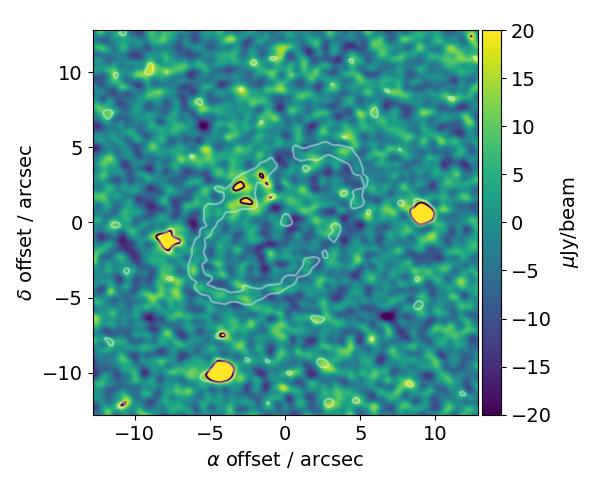

In [20]:
# hd202628
im = 'g_full'
file = 'hd202628/multinest_{}/residual.fits'.format(im)
d = fits.getdata(file).squeeze() * 1e6
h = fits.open(file)
aspp = np.abs(h[0].header['CDELT1']*3600)
sz = d.shape[0] * aspp

file2 = 'hd202628.fits'
d2 = fits.getdata(file2).squeeze() * 1e6

fig, ax = plt.subplots(figsize=(6,5))
_ = ax.imshow(d, origin='bottom', extent=[-sz/2,sz/2,-sz/2,sz/2], vmax=20, vmin=-20)
ax.contour(d, origin='lower', extent=[-sz/2,sz/2,-sz/2,sz/2], levels=[3*6])
# ax.plot(0,0, '+w')

ax.contour(d2, levels=[15], origin='lower', extent=[-sz/2,sz/2,-sz/2,sz/2], colors='white', alpha=0.4)

cb = fig.colorbar(_, pad=0.01, shrink=0.955)
cb.ax.set_ylabel('$\mu$Jy/beam')

ax.set_xlabel(r'$\alpha$ offset / arcsec')
ax.set_ylabel(r'$\delta$ offset / arcsec')

fig.tight_layout()
fig.savefig('figs/hd_res_{}.pdf'.format(im))

In [65]:
# population
names = ['$\eta$ Crv','HD 181327','HR 4796','Fomalhaut','HD 202628']
ref = ['2017MNRAS.465.2595M','2016MNRAS.460.2933M','2018MNRAS.475.4924K','2017ApJ...842....8M','this work']
es = np.array([0.05, 0.018, 0.06, 0.125, 0.12])
e_es = np.array([0, 0, 0.02, .001, 0.01])
r = np.array([152, 86, 78.5, 18.2, 154.3])
dr = np.array([46, 23.2, 10, 2.1, 22.4]) # models, except for Fom (narrower of two ansae)
e_dr = np.array([5, 1, 1, 0.1, 2])

x = np.linspace(0,0.35)

<IPython.core.display.Javascript object>


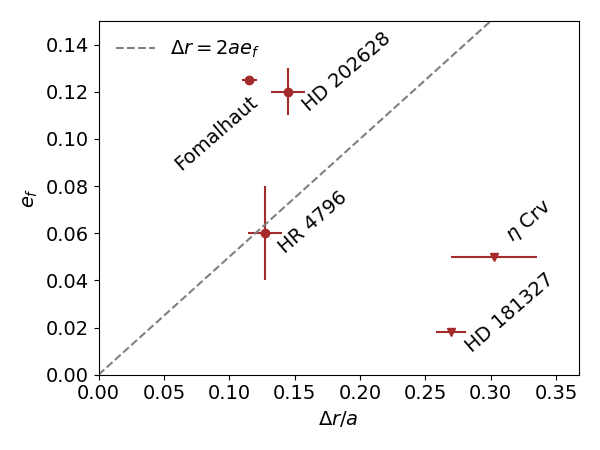

In [72]:
fig, ax = plt.subplots(figsize=(6,4.5))
det = slice(2,5)
ndet = slice(0,2)
# ax.plot(dr[det]/r[det], es[det], '.', color='brown', markersize=12)
ax.errorbar(dr[det]/r[det], es[det], e_es[det], e_dr[det]/r[det], fmt='.', color='brown', markersize=12)
# ax.er(dr[det]/r[det], es[det], '.', color='brown', markersize=12)
# ax.plot(dr[3]/r[3], es[3], '<', color='brown')
# ax.plot(dr[4]/r[4], es[4], '<', color='brown')
ax.plot(dr[ndet]/r[ndet], es[ndet], 'v', color='brown')
ax.errorbar(dr[ndet]/r[ndet], es[ndet], e_es[ndet], e_dr[ndet]/r[ndet], fmt='none', color='brown', markersize=12)

ax.plot(x, x/2, '--', color='grey', label='$\Delta r = 2 a e_f$')

for i,n in enumerate(names):
    if n == 'Fomalhaut':
        ax.text(dr[i]/r[i]-0.06, es[i]-0.04, n,
                verticalalignment='bottom', rotation=41)
    elif n == '$\eta$ Crv':
        ax.text(dr[i]/r[i]+0.006, es[i]+0.004, n,
                verticalalignment='bottom', rotation=41)
    else:
        ax.text(dr[i]/r[i]+0.008, es[i]-0.01, n,
                verticalalignment='bottom', rotation=41)

ax.set_xlabel('$\Delta r/a$')
ax.set_ylabel('$e_f$')
ax.set_ylim(0, 0.15)
ax.set_xlim(0, None)

ax.legend(frameon=False)

fig.tight_layout()
fig.savefig('figs/ew.pdf')